# 1D heat equation 

The following cell implements the 1D heat equation 
$$
\begin{cases}
\partial_t u(x,t) = D \partial_{xx} u(x,t)&
\quad \text{for } t > 0 \quad \text{and} \quad x \in (0,1) \\
u(x,0) = u_0(x) & \quad \text{for} x \in (0, 1) \\
u(0,t) = g_0(t) &\quad \text{for } t > 0 \\
\partial_x u(1,t) = g_1(t) &\quad \text{for } t > 0 
\end{cases}
$$

- The first equation says that heat flows into the direction of the negative heat gradient (e.g. distributes in a diffusive manner). Here, $D$ is the diffusion coefficient, which determines how fast the diffusion is.
- The second equation are the initial conditions, e.g. the initial heat profile.
- Next, we have a so called dirichlet boundary condition. This says that the heat at $x = 0$ is fixed to a certain value $g_0(t)$. (Physically, this could correspond to a surfaces at which the heat is externally controlled. Like a heater for example.)
- Finally, we have a Neumann boundary condition. $g_1(t)$ determines the speed of incoming heat ($g_1(t) > 0$) or outflowing heat ($g_1(t) < 0$). If $g_1(t) = 0$ then there is no heat flow. (Physically, this represents for example a wall with a very low thermal capacity.) 

In [209]:
using OrdinaryDiffEq
 
# Define the problem
function heat_eq(du,u,p,t)
    (; D, dbc_left, nbc_right, dx, freq) = p
    
    for i in eachindex(u)[2:end-1]
        du[i] = D*(u[i-1] - 2*u[i] + u[i+1])
    end

    # Boundary conditions
    du[1]   = D*(dbc_left - 2*u[1] + u[2])
    du[end] = (u[end-1] - u[end]) - dx * nbc_right * ( 1 + sin(freq * 2π * t) )

    return nothing
end


N = 100
L = 1.0
dx = L/N

x = LinRange(dx, L, 100)  # we do not include the left boundary point (Dirichlet BC)
u0 = [ 0.45 < x < 0.55 ? 10.0 : 0.0 for x in x ]
tspan = (0.0, 100.0)
p = ( D = 2.0, dbc_left = 2.0, nbc_right = -100.0, dx, freq = 1/20)

prob = ODEProblem(heat_eq, u0, tspan, p);

In [210]:
sol = solve(prob, Tsit5(), saveat=0.1);

In [211]:
using GLMakie
Makie.inline!(true)
set_theme!(theme_dark())

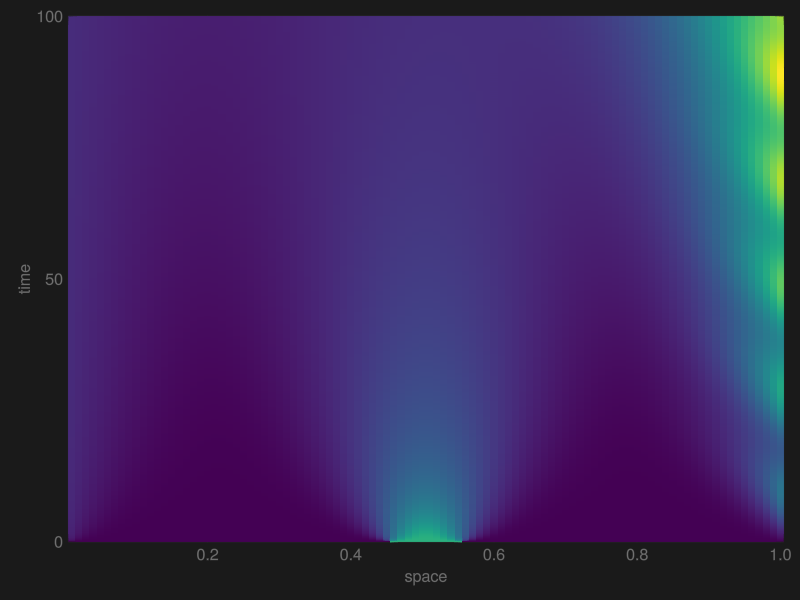

In [223]:
heatmap( x, sol.t, Array(sol), axis = (xlabel = "space", ylabel = "time") )

In [224]:
snapshots = sol( [10.0, 50.0, 100.0])
data = Array(snapshots)

100×3 Matrix{Float64}:
 1.74848    1.8902    1.94174
 1.50321    1.78112   1.88389
 1.26996    1.67337   1.82669
 1.05366    1.56777   1.77071
 0.858034   1.46476   1.71604
 0.68547    1.36528   1.66335
 0.536999   1.26957   1.61257
 0.412385   1.17867   1.56449
 0.31035    1.09262   1.51887
 0.22883    1.01253   1.47659
 ⋮                   
 0.666324   4.58158   8.77801
 0.948178   5.16938   9.36176
 1.32246    5.83995   9.94612
 1.80615    6.60618  10.5246
 2.41419    7.47294  11.0907
 3.15427    8.44292  11.6466
 4.02319    9.50416  12.2033
 4.99926   10.6304   12.7902
 6.03613   11.7693   13.4592

# Here you challenge begins...

Now, imagine that you do not know all parameters... 

Can you use the `snapshots` to find the value of `D`?

In [225]:
# You could use these packages ;)
using Zygote, SciMLSensitivity
using Optimization,OptimizationFlux, OptimizationOptimJL

In [266]:
function predict(x, prob, p, saveat)
    solve(prob, Tsit5(), p = (;p..., D = x[1]), saveat = saveat)
end

predict (generic function with 1 method)

In [267]:
## Defining Loss function
function loss(x, opt_p)
    (; prob, p, snapshots) = opt_p
    l = predict(x, prob, p, snapshots.t) - snapshots
    return sum(abs2, l)
end

268.59749890298195

In [274]:
adtype = Optimization.AutoZygote()
opt_func = Optimization.OptimizationFunction(loss, adtype)
opt_p = (; prob, p, snapshots)
opt_u = [0.0]

1-element Vector{Float64}:
 0.0

In [275]:
optprob = Optimization.OptimizationProblem(opt_func, opt_u, opt_p)

OptimizationProblem. In-place: true
u0: 1-element Vector{Float64}:
 0.0

In [1]:
res = Optimization.solve(optprob, NelderMead())

UndefVarError: UndefVarError: `Optimization` not defined